In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


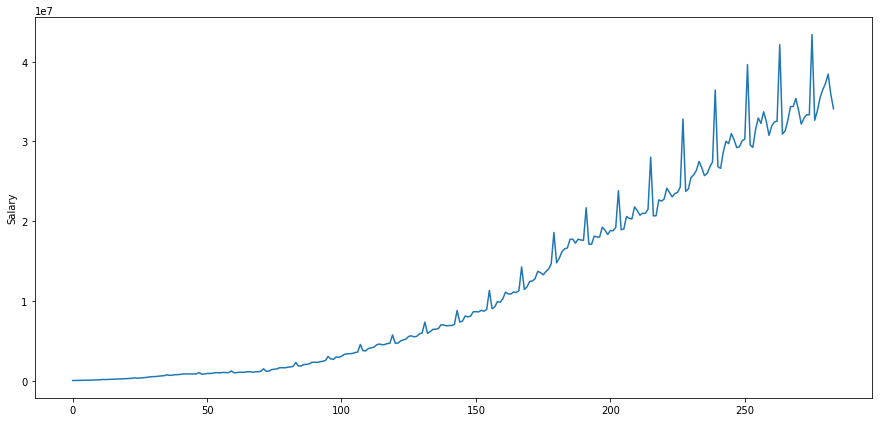

In [2]:
salary = pd.read_csv('WAG_C_M.csv',';')
salary.WAG_C_M = salary.WAG_C_M * 1000
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Необходимо стабилизировать дисперсию

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


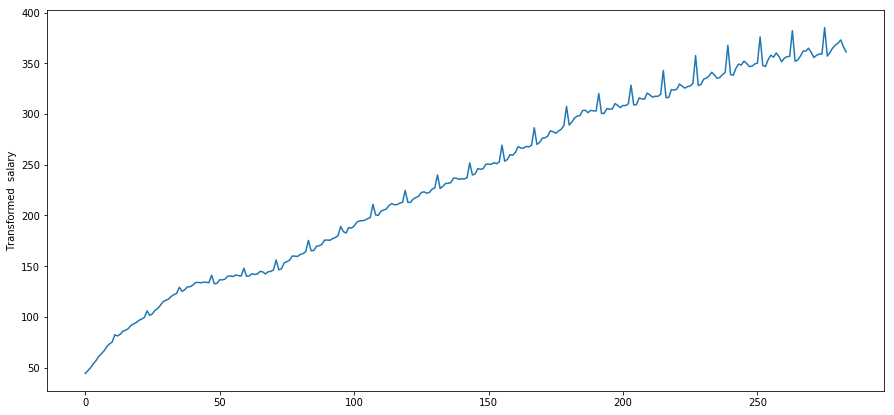

In [3]:
salary['salary_box'], lmbda = stats.boxcox(salary['WAG_C_M'])
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed  salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

Критерий Дики-Фуллера не отвергает гипотезу о нестационраности ряда. Поэтому необходимо применить дифференцирование. Сначала сезонное

Критерий Дики-Фуллера: p=0.014697


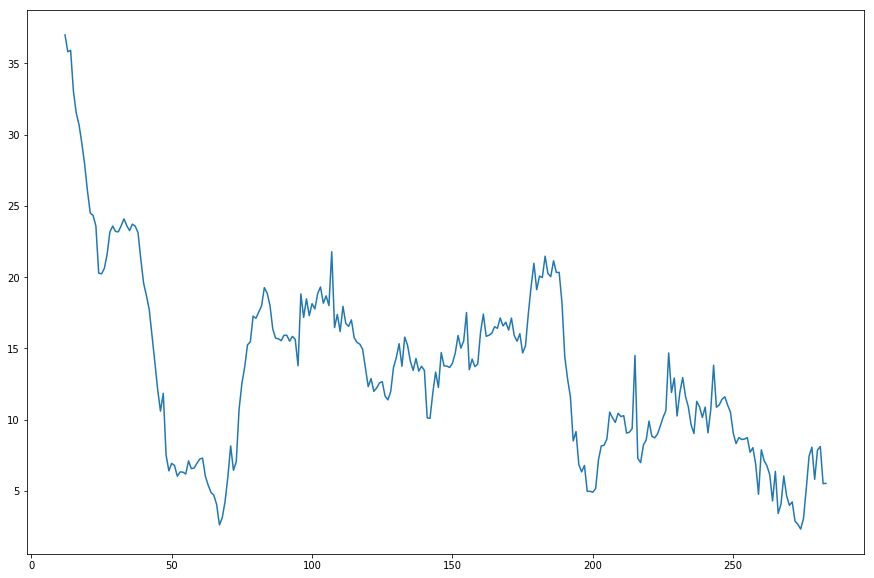

In [4]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
salary.salary_box_diff.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Ряд стоит продифферинцировать еще один раз. Теперь уже применяется обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


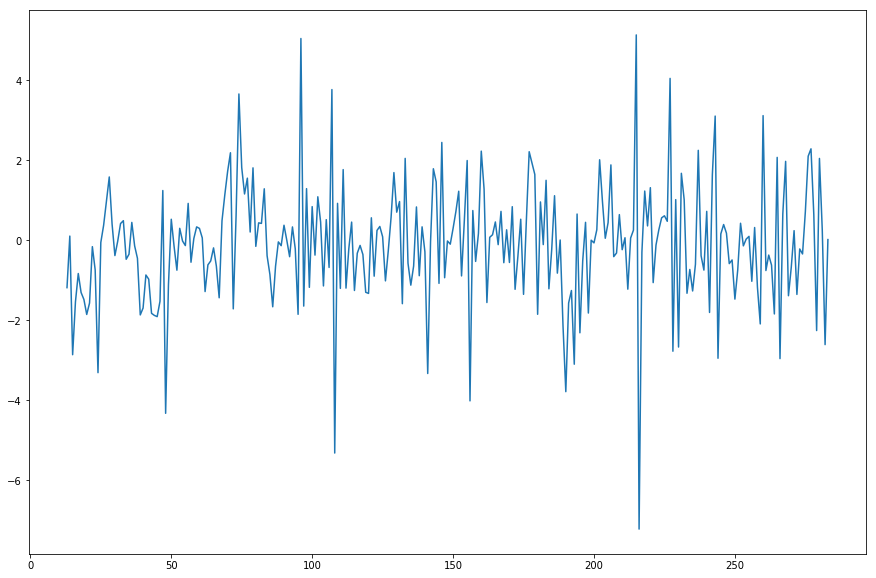

In [5]:
salary['salary_box_diff_1'] = salary.salary_box_diff[12:] - salary.salary_box_diff[12:].shift(1)
plt.figure(figsize(15,10))
salary.salary_box_diff_1.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff_1[13:])[1])

Можно сказать, что полученный ряд является стационарным d = 1 ; D = 1. Далее подбор остальных параметров

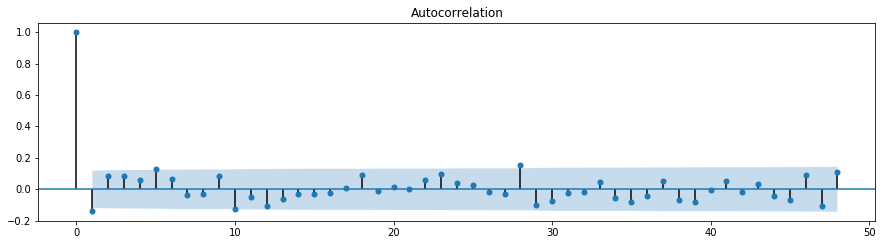

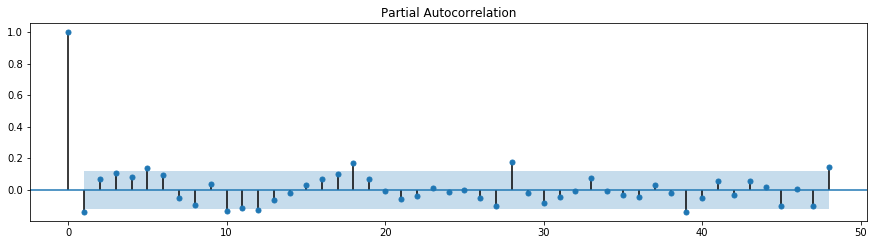

In [6]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff_1[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff_1[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальное приближение: q = 1; Q = 0; p = 1; P = 4

In [7]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(2, 6)
D=1
Qs = range(0, 2)

In [8]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [9]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 2, 1))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 3, 1))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (1, 2, 4, 1))
('wrong parameters:', (1, 2, 5, 0))
('wrong parameters:', (1, 2, 5, 1))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 3, 1))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 1, 4, 1))
('wrong parameters:', (2, 1, 5, 0))
('wrong parameters:', (2, 1, 5, 1))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 2, 1))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (2, 2, 3, 1))
('wrong parameters:', (2, 2, 4, 0))
('wrong parameters:', (2, 2, 4, 1))
('wrong parameters:', (2, 2, 5, 0))
('wrong parameters:', (2, 2, 5, 1))
Wall time: 6min 8s


In [10]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
29  (1, 0, 4, 1)  977.127844
13  (0, 1, 4, 1)  977.458239
31  (1, 0, 5, 1)  978.232179
21  (0, 2, 4, 1)  978.238592
5   (0, 0, 4, 1)  978.410606


In [11]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(4, 1, 1, 12)   Log Likelihood                -481.564
Date:                            Sat, 29 Dec 2018   AIC                            977.128
Time:                                    16:16:10   BIC                           1002.343
Sample:                                         0   HQIC                           987.252
                                            - 284                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1129      0.053     -2.148      0.032      -0.216      -0.010
ar.S.L12       0.7406      0.100   

Критерий Стьюдента: p=0.790167
Критерий Дики-Фуллера: p=0.000016


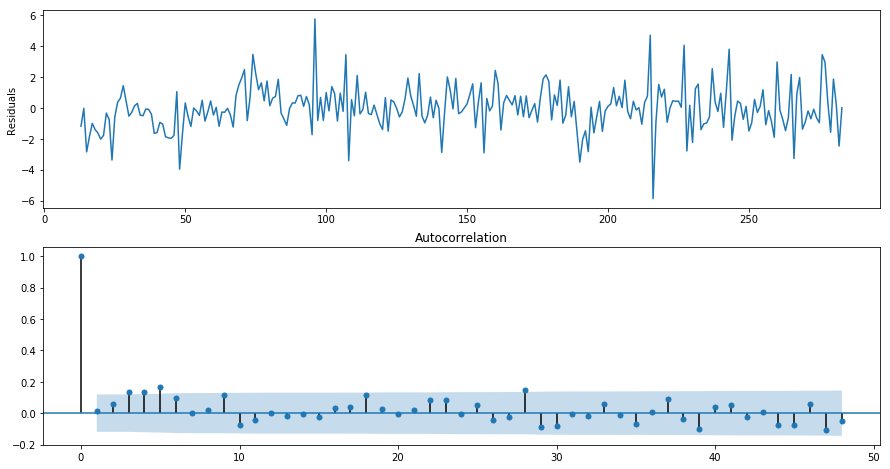

In [12]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

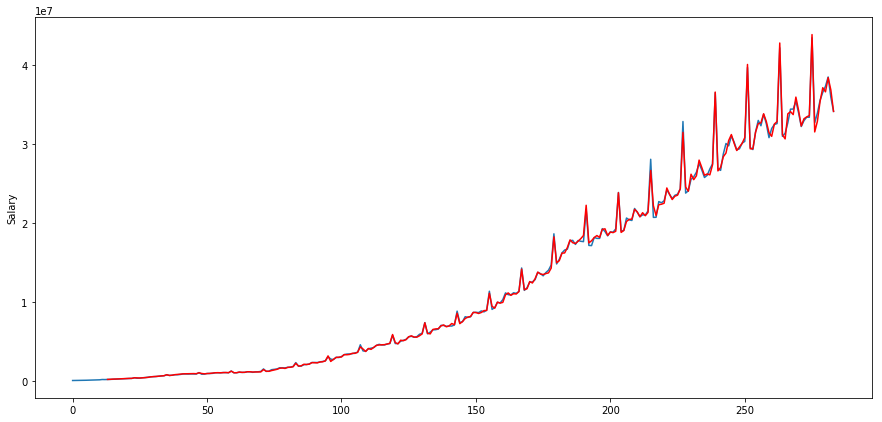

In [13]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

### Прогноз

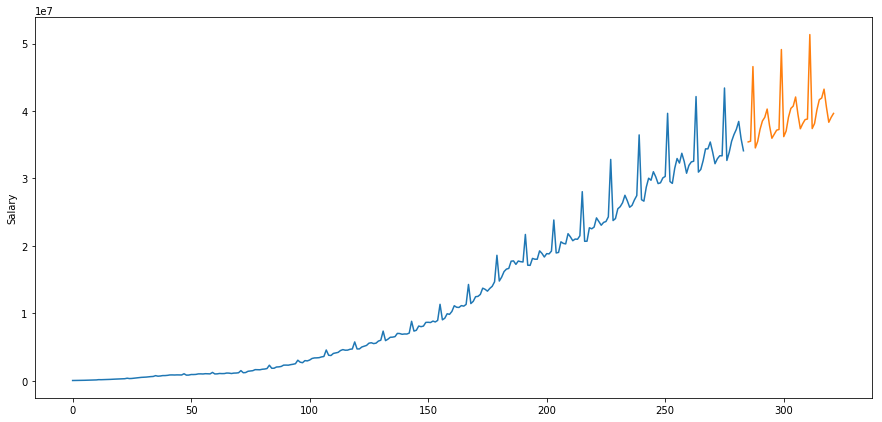

In [23]:
plt.figure(figsize(15,7))
x = range(285,322)
y = invboxcox(best_model.predict(start=285, end=321), lmbda)
salary.WAG_C_M.plot()
plt.plot(x,y)
plt.ylabel('Salary')
pylab.show()